In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pylab as plt

import sys

from data import *
from modules import *

# Define model

In [2]:
class bf_lin(nn.Module):
    def __init__(self):
        super(bf_lin, self).__init__()
        self._a     = nn.Parameter(torch.rand(()))
        self._b     = nn.Parameter(torch.rand(()))
        self._k_x   = nn.Parameter(torch.rand(()))
        self._k_y   = nn.Parameter(torch.rand(()))
        self.sampler = torch.distributions.Beta(2., 2.)

    def forward(self, _Y, Nhrzn):
# _Y: (Nwup+1, *, Ny=1)
        Nx = 1
        Nw = 1
        Nwup = _Y.shape[0] - 1
        Nbatch = _Y.shape[1]
        
        _a = self._a 
        _b = self._b 

        _x = _Y[0,:] # (*, Ny = Nx = 1)
        X = [_x,]
        W = []
        for k1 in range(1, Nwup + 1 + Nhrzn):
            if k1 <= Nwup:
                _w =  torch.tanh((self._k_y * _Y[k1,:] + self._k_x * _x)/2) # (*, Nw)
                _x = _a * _x + torch.sqrt(1-_a**2) * _b * _w # (*, Nx)
                X.append(_x)
                W.append(_w)
            else:
                if self.training:
                    _w = torch.zeros(Nbatch, Nw)
                else:
                    _w = 2 * self.sampler.sample((Nbatch, Nw)) - 1
                _x = _a * _x + torch.sqrt(1-_a**2) * _b * _w
                X.append(_x)
                
        _X = torch.stack(X, dim=0) # (Nhrzn+1, *, Nx)
        _Yhat = _X.clone() # (Nhrzn+1, *, Ny)
        if Nwup > 0:
            _W = torch.stack(W, dim=0) # (Nwup, *, Nw)
        else:
            _W = torch.zeros(Nwup, Nbatch, Nw)

        return _Yhat, _W

# Define training procedure

In [3]:
def run_training(mdl, optimizer, data_generator, Nepoch, Nbatch, Nwup, Nhrzn, 
    eps_given, max_itr, norm_p, pickup_size, mix_axes, reg_param):
    
    mdl.train()

    Ny = data_generator.Nx
    Nw = 1

    sampler = mdl.sampler

    Nitr = data_generator.Ntrain//Nbatch

    loss_hist = []
    for epoch in range(Nepoch):
        tmp = []
        for k1 in range(Nitr):
            Y = data_generator.batch(Nbatch, Nwup + 1 + Nhrzn) # (Nwup+Nhrzn+1, *, 1)
            _Y = torch.tensor(Y) # (Nwup+Nhrzn+1, *, 1)
            _Yhat, _W = mdl(_Y[:Nwup+1,:], Nhrzn) # _Yhat: (Nwup+Nhrzn+1, *, 1), _W: (Nwup, *, 1)
            _resid = torch.mean((_Yhat - _Y)**2)

#             _testW = _W.reshape(-1) # (Nbatch * Nwup * Nw
#             _testW = _testW[torch.randint(0, Nbatch*Nwup*Nw, 
#                 size=(Nbatch, pickup_size,))]
#             _dist, cnt = measure_distance( _testW, sampler.sample(_testW.shape),
#                 eps_given = eps_given, norm_p = norm_p, max_itr = max_itr)

            _testW1 = _W[:, torch.randint(0, Nbatch, size=(pickup_size,)), 0] # (Nwup, 1)
            _testW2 = _W[torch.randint(0, Nwup, size=(pickup_size,)), :, 0] # (Nbatch, 1)

            _dist1, cnt = measure_distance( _testW1, 2*sampler.sample(_testW1.shape)-1,
                eps_given = eps_given, norm_p = norm_p, max_itr = max_itr)
            _dist2, cnt = measure_distance( _testW2, 2*sampler.sample(_testW2.shape)-1,
                eps_given = eps_given, norm_p = norm_p, max_itr = max_itr)
            _dist = _dist1 + _dist2

            _loss = _resid +_dist * reg_param

            sys.stdout.write('%04d/%04d %04d/%04d\r' % 
                (epoch, Nepoch, k1, Nitr,))
            tmp.append((float(_resid), float(_dist1), float(_dist2), float(_dist), float(_loss),))
        
            mdl.zero_grad()
            _loss.backward()
            optimizer.step()
        loss_hist.append((epoch, *np.mean(tmp, axis=0)))
    return np.array(loss_hist)

# Training 001:

In [4]:
Nepoch      = 2**10
Nbatch      = 2**7
Nwup        = 2**5
Nhrzn       = 0
eps_given   = 0.1
max_itr     = 2**5
norm_p      = 2
pickup_size = 1
mix_axes    = True
reg_param   = 1.

In [5]:
# Initialize data generator
data_generator = GeneratorFromRandomWalk(TimeConstant = 10.)

# Training
bf = bf_lin()

optimizer = torch.optim.Adam(bf.parameters())

loss_hist = run_training(bf, optimizer, data_generator, Nepoch, Nbatch, Nwup, Nhrzn, 
    eps_given, max_itr, norm_p, pickup_size, mix_axes, reg_param)

In [6]:
print('a', float(bf._a))
print('b', float(bf._b))
print('k_x', float(bf._k_x))
print('k_y', float(bf._k_y))

a 0.9307454228401184
b 5.422715663909912
k_x -0.9511930346488953
k_y 1.0289721488952637


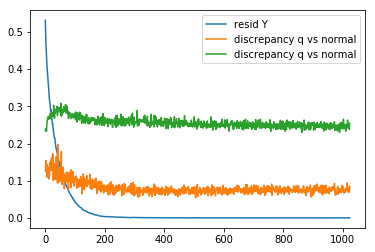

In [7]:
plt.plot(loss_hist[:,0], loss_hist[:,1], label = 'resid Y')
plt.plot(loss_hist[:,0], loss_hist[:,2], label = 'discrepancy q vs normal')
plt.plot(loss_hist[:,0], loss_hist[:,3], label = 'discrepancy q vs normal')
plt.legend()
plt.yscale('linear')
#plt.ylim([0,100])

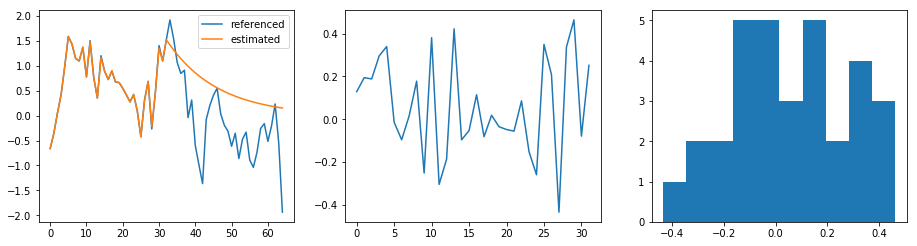

In [8]:
bf.train()
Nhrzn = 2**5
Ybatch = data_generator.batch(Nbatch=1, N=Nwup+Nhrzn+1)
_Ybatch = torch.tensor(Ybatch)
_Yhat, _W = bf(_Ybatch[:Nwup+1,:], Nhrzn)
Yhat = _Yhat.data.numpy() # (Nhrzn+1, *, Ny)
W = _W.data.numpy() # (Nhrzn, * , Ny)

plt.figure(figsize=[40/2.57, 10/2.57])
#
plt.subplot(1,3,1)
plt.plot(Ybatch[:,0,0], label = 'referenced')
plt.plot(Yhat[:,0,0], label = 'estimated')
plt.legend()
#
plt.subplot(1,3,2)
plt.plot(W[:,0,0])
#
plt.subplot(1,3,3)
plt.hist(W[:,0,0])
pass

In [9]:
bf.train()
Ybatch = data_generator.batch(Nbatch=2**10, N=Nwup+Nhrzn+1)
_Ybatch = torch.tensor(Ybatch)
_Yhat, _W = bf(_Ybatch[:Nwup+1,:], Nhrzn)
Yhat = _Yhat.data.numpy() # (Nhrzn+1, *, Ny)
W = _W.data.numpy() # (Nhrzn, * , Ny)

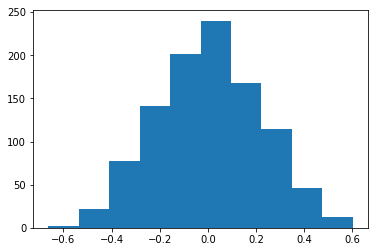

In [10]:
plt.hist(W[0,:,0]);

In [11]:
bf.eval()
Nbatch = 2**7
Ybatch = data_generator.batch(Nbatch=1, N=Nwup+1)
_Ybatch = torch.tensor(np.repeat(Ybatch, Nbatch, axis=1))
_Yhat, _ = bf(_Ybatch[:1,:], Nwup)
Yhat = _Yhat.data.numpy() # (Nhrzn+1, *, Ny)

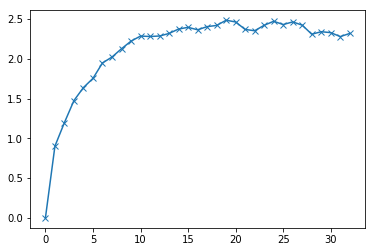

In [12]:
plt.plot(np.std(Yhat, axis=1),'-x')